# Tutorial to Work with a GOES-R (Geostationary) ABI Level 2 Data File

This code was written in December 2022 by Dr. Rebekah Esmaili, STC at NOAA/JPSS (rebekah.esmaili@noaa.gov) and Dr. Amy Huff, IMSG at NOAA/NESDIS/STAR (amy.huff@noaa.gov).

This tutorial will demonstrate how to work with an ABI Level 2 netCDF4 file, including how to work with the ABI fixed grid/GOES Imager projection and what aspects to consider when making beautiful composite color (RGB) imagery.

The main steps are:
- Open the file
- Read the global file metadata & the metadata for variables in the file
    - Recognize the GOES Imager fixed grid projection variables
- Combine ABI band data variables to make different types of composite RGB imagery
- Plot composite RGB imagery using the native geostationary map projection
- Save image file

## Topic 1-2: Launch Jupyter Notebooks

### Import Python packages

We will use three Python packages (libraries) and two Python modules in this tutorial:
- The **xarray** library is used to work with labelled multi-dimensional arrays
- The **NumPy** library is used to perform array operations
- The **Matplotlib** library is used to make plots
- The **datetime** module is used to manipulate dates and times
- The **pathlib** module is used to set filesystem paths for the user's operating system

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import datetime
from pathlib import Path
from cartopy import crs as ccrs
import cartopy.feature as cfeature

### Set directory path and file name for satellite data file

We set the directory path for the satellite data file using the **pathlib** module, which automatically uses the correct format for the user's operating system. This helps avoid errors in situations when more than one person is using the same code file, because Windows uses back slashes in directory paths, while MacOS and Linux use forward slashes. 

More information about the **pathlib** module: https://docs.python.org/3/library/pathlib.html#module-pathlib

To keep things simple for this training, we put the satellite data files we downloaded in the current working directory ("cwd"), i.e., the same Jupyter Notebook folder where this code file is located.

We set the "directory_path" as the current working directory and the "file_name" of the netCDF4 satellite data file, and then set the full path for the data file ("file_id") using **pathlib** syntax.

In [2]:
directory_path = Path.cwd()
file_name = 'OR_ABI-L2-MCMIPM2-M6_G16_s20223362030552_e20223362031017_c20223362031113.nc'
file_id = directory_path / file_name

## Topic 3: Understand the structure and contents of the file(s)

### Open satellite data file using xarray & read metadata

We open the satellite data file using "xarray.open_dataset" and then print the file metadata. The contents of a satellite data file are called a "Dataset" in **xarray**, conventionally abbreviated as "ds". 

The global file metadata are listed under "Attributes".

For any of the "Data variables" or "Coordinates", click on the attributes icon (little page) to see array metadata and the data repository icon (little server) to see an array summary.

The satellite data in the file are displayed under "Data variables".  A data variable is called a "DataArray" in **xarray**, conventionally abbreviated as "da". We are going to focus on the Cloud and Moisture Imagery (CMI) for the 16 ABI bands, also called channels (C); for example, "CMI_C01" is the CMI reflectance value for band (channel) 1.  We will also need the information in the "goes_imager_projection" data variable, which are constants that describe the fixed ABI grid for the GOES-16 satellite geostationary projection.

Notice that there is no array for latitude or longitude ing the "Coordinates".  To save file space, ABI L1b and L2 data files do not contain latitude and longitude. 

In [3]:
ds = xr.open_dataset(file_id, engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                                 (y: 500, x: 500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.117 0.117 ... 0.08907
  * x                                       (x) float64 -0.07277 ... -0.04483
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2022-12-02T20:31:11.3Z
    time_coverage_start:       2022-12-02T20:30:55.2Z
    time_coverage_end:         2022-12-02T20:31:01.7Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        9c8ac194-48e9-47a9-a5b3-8f4ce24e3f5f

The GOES-16 ABI instrument [has 16 bands](https://www.goes-r.gov/mission/ABI-bands-quick-info.html) or channels. Each channel has a central wavelength that were selected to target certain atmospheric phenomena. For example, Channel 1 has a central wavelength of 0.47 µm. In the file, the channels are abbreviated as CMI_C01, CMI_C02, ..., CMI_C16. 

Let's look at the attributes of on the channels to learn more about the variable:

In [4]:
ds.CMI_C01.attrs

{'long_name': 'ABI Cloud and Moisture Imagery reflectance factor',
 'standard_name': 'toa_lambertian_equivalent_albedo_multiplied_by_cosine_solar_zenith_angle',
 'sensor_band_bit_depth': 10,
 'downsampling_method': 'average',
 'valid_range': array([   0, 4095], dtype=int16),
 'units': '1',
 'resolution': 'y: 0.000056 rad x: 0.000056 rad',
 'grid_mapping': 'goes_imager_projection',
 'cell_methods': 't: point area: sum (interval: 0.000028 rad)',
 'ancillary_variables': 'DQF_C01'}

When you see units set to '1', it means it's a unitless quantity. However, we can learn that the data are reflectances for the that particular channel. Reflectance is the amount quantity of incoming radiation at that particular wavelength that is reflected back up and ranges from 0 (absorbing) to 1 (reflective). Reflectance is a common unit for visible and near-IR bands (ABI channels 1-6) whereas IR bands are reported in brightness temperature (ABI channels 7-16), which is expressed in Kelvin.

In [5]:
ds.CMI_C13.attrs

{'long_name': 'ABI Cloud and Moisture Imagery brightness temperature at top of atmosphere',
 'standard_name': 'toa_brightness_temperature',
 'sensor_band_bit_depth': 12,
 'valid_range': array([   0, 4095], dtype=int16),
 'units': 'K',
 'resolution': 'y: 0.000056 rad x: 0.000056 rad',
 'grid_mapping': 'goes_imager_projection',
 'cell_methods': 't: point area: point',
 'ancillary_variables': 'DQF_C13'}

## Topic 4: Handling data arrays

### How to create an RGB plot
To make an RGB, we will need to define three arrays, one for each color. We can use the imshow function within matplotlib to display an image of 3 two-dimensional arrays, each representing red, green, and blue.

Each of these arrays must:
* The data values span 0.0-1.0 floats
* Be two-dimensional and the same size
* Be stacked "horizontally" or on the third dimension. The shape of the final array will be (X,Y,3)

Let's explore a simple example below. We'll populate 2x2 arrays with fake

In [6]:
# top left | top right | bottom left | bottom right
red   = np.array( [ [ 1.0, 0.0 ], [ 0.0, 1.0] ] )
green = np.array( [ [ 0.0, 1.0 ], [ 0.0, 0.0] ] )
blue  = np.array( [ [ 0.0, 0.0 ], [ 1.0, 1.0] ] )

rgb = np.dstack([red, green, blue])

print(rgb.shape)

(2, 2, 3)


np.dstack() concatenates the given arrays horizontally. This function is also equivalent to np.stack([r,g,b], axis=2). A quick check of the shape above shows the shape meets the shape requirements (X,Y,3) and the data we entered into the arrays is between 0 and 1. If the data are outside of that range, they are automatically "clipped" 1.0. It's best to manually scale the data though to make sure you're getting the results that you expect.

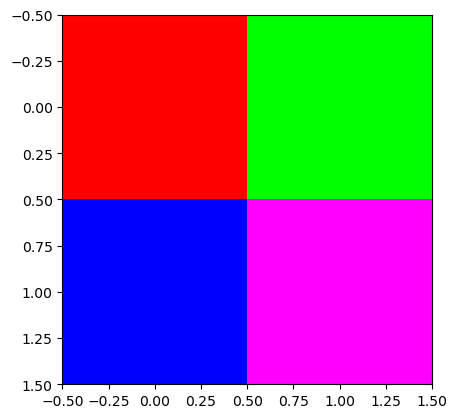

In [7]:
plt.figure()
plt.imshow(rgb)
plt.show()

Let's perform our three check for the values inside our datasets. Do the min and max lie within 0 and 1?

In [8]:
ds['CMI_C01'].values.min(), ds['CMI_C01'].values.max()

(0.06603168, 0.56888837)

Next, let's check the size. In this example, all the data are the same size (this is not true for all files!). Lets compare channels 1, 2, and 3:

In [9]:
ds['CMI_C01'].shape, ds['CMI_C02'].shape, ds['CMI_C03'].shape

((500, 500), (500, 500), (500, 500))

They have the same dimensions, so we can continue. If the arrays are not the same size, then some or all of the data need to be re-gridded. For illustrative purposes, lets say we want to coarsen channel 1 by a factor of 2. We could change the size using numpy indexing:

In [10]:
ch1 = ds['CMI_C01']
ch1_resize = ch1[::2,::2]
ch1.shape, ch1_resize.shape

((500, 500), (250, 250))

We'll perform check 3 where we stack the three channels in the next section!

## Topic 5: Create a basic RGB image
### True Color RGB

True color imagery has delighted both scientists and the public since the beginning of the satellite age. These images are constructed from three layers, which respectively are red, green, and blue. To learn more, check out the [True Color RGB quick guide](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf) from Colorado State University's Cooperative Institute for Research in the Atmosphere.

In the GOES-16 ABI, we'll need the following "recipe" to make a True Color image:


|Color|central wavelength (µm)|channel | min - max (reflectance) | gamma |
|----|---|---|---|---|
|Red |0.64|2|0-1|1|
|Green|0.45\*Red + 0.1\*Veggie + 0.45\*Blue|2,3,1|0-1|1|
|Blue|0.47|1|0-1|1|

The GOES-R series ABI sensor does not have a channel that detects the green wavelengths. Instead, it can be derived from a linear relationship between the red, blue, and another nicknamed the veggie channel. Let's extract these data arrays from our dataset:

In [11]:
ch1 = ds.CMI_C01
ch2 = ds.CMI_C02
ch3 = ds.CMI_C03

As we discussed earlier, since these are visible bands, the values are reflectances and thus unitless;they already span 0-1. We also already checked the shape and size.

Use the formula in the table above to linearly combine the three arrays

In [12]:
green = 0.45*ch2 + 0.1*ch3 + 0.45*ch1

Is this new green channel still in range? Let's check:

In [45]:
green.values.min(), green.values.max()

(0.045904715, 0.56068194)

We can use np.stack to combine the three arrays into a single 3D array. We stack in order of red, green, blue:

In [14]:
tc_RGB = np.dstack([ch2, green, ch1])

Let's make a quick plot using imshow. Each of the three arrays will be respectively converted into red, green, and blue to create a color image.

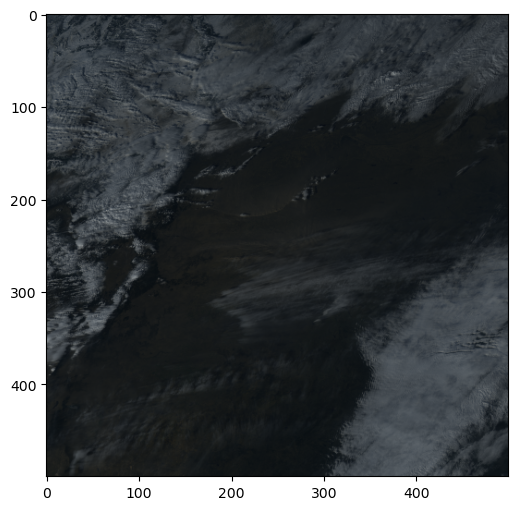

In [15]:
plt.figure(figsize=[6,6])
plt.imshow(tc_RGB)
plt.show()

We can see some features in the scene such as clouds and the underlying surface. However, the above image is a quite dark. This can be adjusted using an image gamma correction. Gamma adjusts the luminance in images. It can be calculated from the formula:

array**1/gamma

Higher gamma values will brighten that color array while lower ones will darken. Let's arbitrarily pick a gamma of 2 to increase the brightness of the image:

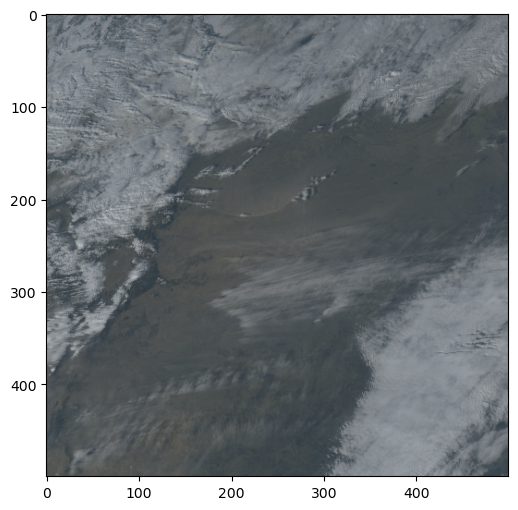

In [16]:
gamma = 2
tc_RGB_gamma = np.power(tc_RGB, 1/gamma)

plt.figure(figsize=[6,6])
plt.imshow(tc_RGB_gamma)
plt.show()

### Dust RGB

Just because we're working in RGB space doesn't limit us to only using the red, green, blue channels. We can combine any of the ABI channels to produce imagery. Since some channels are more sensitive to atmospheric constituents than others, RGB images can help distinguish natural features. We can also employ channel differencing to highlight specific atmospheric features.

Let's create a dust RGB image of the same scene next. The recipe below comes from CIRA's [Dust RGB quick guide](https://rammb.cira.colostate.edu/training/visit/quick_guides/Dust_RGB_Quick_Guide.pdf).

|color layer|central wavelength (µm)|channel | min - max (K) | gamma |
|----|---|---|---|---|
|Red |12.3 - 10.3|15 - 13| -6.7 to 2.6 |1|
|Green|11.2 - 8.2|14 - 11| -0.5 to 20.0 |2.5|
|Blue|10.3 |13 | 261.2 to 288.7 |1|

Just like before, let's extract the channels we need:


In [17]:
ch11 = ds.CMI_C11
ch13 = ds.CMI_C13
ch14 = ds.CMI_C14
ch15 = ds.CMI_C15

From row describing the red layer in the table above, we will need to take the difference of channels 15 and 13:

In [18]:
img = ch15-ch13

Because we are using IR bands, the data are in brightness temperature. Thus, we will need to normalize the data [using the given min max ranges](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)) so that it's on a 0 to 1 scale. This will look like:

$$ X_{norm} = {X - X_{min} \over X_{max} - X_{min} } $$

In [19]:
lower_val = -6.7
upper_val = 2.6

# Sets all data above 2.6 to 1.0 and all data below -6.7 to 0:
img_clip = np.clip(img, lower_val, upper_val)
# Normalizes the clipped data
normalized_red = (img_clip-lower_val)/(upper_val-lower_val)

Let's check if these values are in range:

In [20]:
normalized_red.values.min(), normalized_red.values.max()

(0.0, 0.8110213)

According to our recipe, the gamma is 1 and thus does not need to be changed. So, our red layer is now complete. Let's move on to the green layer:

In [21]:
img = ch14-ch11

lower_val = -0.5
upper_val = 20.0

img_clip = np.clip(img, lower_val, upper_val)
normalized_green = (img_clip-lower_val)/(upper_val-lower_val)

The green layer requires requires a gamma correction.

In [22]:
gamma = 2.5
normalized_green_gamma = np.power(normalized_green, 1/gamma)

In [23]:
img = ch13

lower_val = 261.2
upper_val = 288.7

img_clip = np.clip(img, lower_val, upper_val)
normalized_blue = (img_clip-lower_val)/(upper_val-lower_val)

In [24]:
dust_RGB = np.dstack([normalized_red, normalized_green_gamma, normalized_blue])

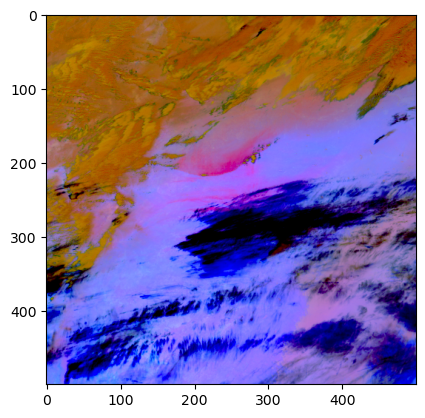

In [42]:
plt.figure()
plt.imshow(dust_RGB)
plt.show()

### Exercise RGB-1: Create a Airmass RGB image

[Airmass RGB](https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_AirMassRGB_final.pdf) are used by meteorologists to easily display regions of polar and tropical air masses. Below is the recipe:

|Color|central wavelength (µm)|channel | min - max (K) | gamma |
|----|---|---|---|---|
|Red |6.2 – 7.3|8, 10 |-26.2 to 0.6 |1|
|Green|9.6 – 10.3|12, 13| -43.2 to 6.7 |1|
|Blue|6.2 (inverted)|8|244.0, 208.5|1|

Note: By inverted, we mean once the data are scaled to 0-1, you subtract 1-blue. So, low values (0) become high values (1), and vice versa.

Construct an image below, some of the code is provided:

In [26]:
ch8 = ds.CMI_C08
ch10 = ds.CMI_C10
ch12 = ds.CMI_C12
ch13 = ds.CMI_C13

In [27]:
# Red
img = ch8-ch10

lower_val = -26.2
upper_val = 0.6

img_clip = np.clip(img, lower_val, upper_val)
normalized_red = (img_clip-lower_val)/(upper_val-lower_val)

In [28]:
# Green
img = ch12-ch13

lower_val = -43.2
upper_val = 6.7

img_clip = np.clip(img, lower_val, upper_val)
normalized_green = (img_clip-lower_val)/(upper_val-lower_val)

In [29]:
# Blue
img = ch8

lower_val = 208.5
upper_val = 244

img_clip = np.clip(img, lower_val, upper_val)
normalized_blue = (img_clip-lower_val)/(upper_val-lower_val)
normalized_blue_inverted = 1-normalized_blue

In [30]:
airmass_RGB = np.dstack([normalized_red, normalized_green, normalized_blue_inverted])

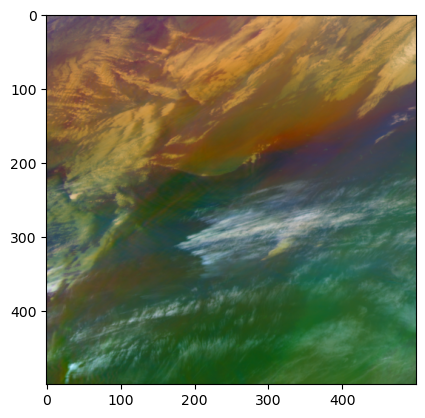

In [41]:
plt.figure()
plt.imshow(airmass_RGB)
plt.show()

## Topic 6: Working with map projections

Now we can proceed to plotting our satellite data on a map. 

We set up a figure in **Matplotlib** and add "geoaxes" with a map projection using **Cartopy**. There are many different map projection options. Our VIIRS Level 3 gridded data is a global dataset, so we are focusing on global map projections for this tutorial. 

Here is a list of [**Cartopy**](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html) map projections. The VIIRS AOD notebook (viirs_aod.ipynb) walks through several examples of these in greater detail.

You may have noticed that this file does not have latitude and longitude coordinates; many of the GOES ABI products are stored on a geostationary grid. We can extract information about the GOES satellite orbit directly from the netcdf file to make our plot, which in turn can be used by Cartopy to project onto a geostationary grid.

In [32]:
proj_var = ds.goes_imager_projection

sat_height = proj_var.perspective_point_height
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

The plotting function argument **"transform=ccrs.Geostationary()"** tells **Cartopy** that the rgb data are in geostationary coordinates. This argument **must** be included when plotting satellite data that are in geographic coordinates, or the data will not plot correctly on the map projection.

Recall that geostationary satellites are always looking at a fixed point on the Earth's surface. The fixed point and satellite height are different on GOES-16/-17/-18 and on international partner satellites, like Meteosat and Himawari. The central latitude is included in the file, but thus far, all GOES satellites are centered on the equator, and the default value for central_latitude in the function is 0.

In [33]:
central_lon = proj_var.longitude_of_projection_origin
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

It's also important to define the extent of the image. This tells Cartopy the boundaries of the image (versus that of the map). We do this by multiplying the x and y values (which is essentially the viewing angle of the satellite) by the height of the satellite. The smallest and largest values of each show the extent.

In [34]:
X = ds['x']*sat_height
Y = ds['y']*sat_height
imgExtent = (X.min(), X.max(), Y.min(), Y.max())

Finally, let's make a plot! You can switch the projection to Plate Carree by commenting out the second line. 

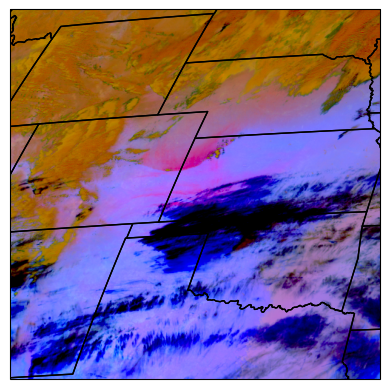

In [40]:
proj_to = crs
# proj_to = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.subplot(projection=proj_to)

ax.coastlines('10m', linewidth=2)
ax.imshow(dust_RGB, origin='upper', extent=imgExtent, transform=crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

plt.show()

## Step 7: Professional touches

In [36]:
ds.attrs

{'naming_authority': 'gov.nesdis.noaa',
 'Conventions': 'CF-1.7',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'standard_name_vocabulary': 'CF Standard Name Table (v35, 20 July 2016)',
 'institution': 'DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services',
 'project': 'GOES',
 'production_site': 'NSOF',
 'production_environment': 'OE',
 'spatial_resolution': '2km at nadir',
 'orbital_slot': 'GOES-East',
 'platform_ID': 'G16',
 'instrument_type': 'GOES-R Series Advanced Baseline Imager (ABI)',
 'scene_id': 'Mesoscale',
 'instrument_ID': 'FM1',
 'dataset_name': 'OR_ABI-L2-MCMIPM2-M6_G16_s20223362030552_e20223362031017_c20223362031113.nc',
 'iso_series_metadata_id': '8c9e8150-3692-11e3-aa6e-0800200c9a66',
 'keywords_vocabulary': 'NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0',
 'title': 'ABI L2 Cloud and Moisture Imagery',
 'summ

In [37]:
platform = ds.platform_ID + ' ' + ds.title[0:3]

dtinfo_s = ds.time_coverage_start[0:16].replace('T',' ')
dtinfo_e = ds.time_coverage_end[0:16].replace('T',' ')

dt_scan = datetime.datetime.strptime(dtinfo_s, '%Y-%m-%d %H:%M')
date_s = dt_scan.strftime('%d %b %Y')
time_s = dt_scan.strftime('%H:%M')

# time = + str(file_name).split('_')[-3][8:10] + ':' + str(file_name).split('_')[-3][10:12] + ' UTC'

composite = 'Dust RGB Composite'
formula = r'$Red = BT_{12.3\mu m}-BT_{10.3\mu m} \ \ \ Green = BT_{11.2\mu m}-BT_{8.4\mu m} \ \ \ Blue = BT_{10.3\mu m}$'

plot_title = platform + ' ' + composite + ' ' + time_s + '\n' + formula

In [38]:
plot_title

'G16 ABI Dust RGB Composite 20:30\n$Red = BT_{12.3\\mu m}-BT_{10.3\\mu m} \\ \\ \\ Green = BT_{11.2\\mu m}-BT_{8.4\\mu m} \\ \\ \\ Blue = BT_{10.3\\mu m}$'

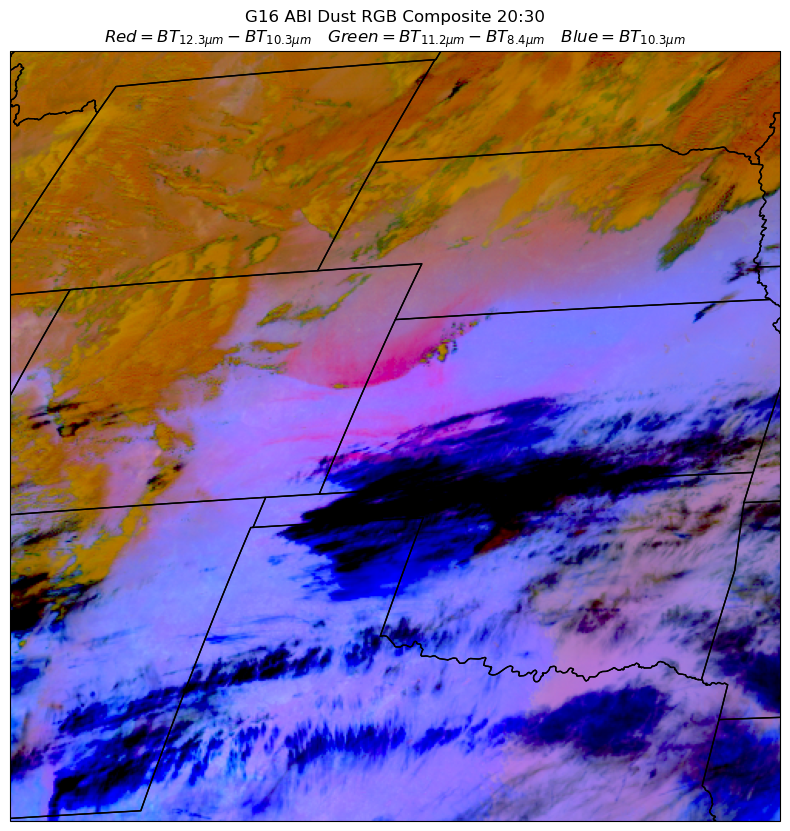

In [46]:
proj_to = crs
# proj_to = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=proj_to)

ax.coastlines('10m', linewidth=2)
ax.imshow(dust_RGB, origin='upper', extent=imgExtent, transform=crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

plt.title(plot_title)
plt.show()